# AMALi cloud top height
This example presents the cloud top height derived from Airborne Mobile Aerosol Lidar for Arctic research (AMALi) measurements. The dataset is available on the [PANGAEA database](https://doi.pangaea.de/10.1594/PANGAEA.932454).

If you have questions or if you would like to use the data for a publication, please don't hesitate to get in contact with the dataset authors as stated in the dataset attributes `contact` or `author`.

## Data access
Some of the data, like the preliminary data of the HALO-(AC)3 campaign, is stored on the (AC)3 nextcloud server. This requires username and password as credentials (registration) that need to be loaded from environment variables

In [1]:
import os
ac3cloud_username = os.environ['AC3_USER']
ac3cloud_password = os.environ['AC3_PASSWORD']

To analyse the data they first have to be loaded by importing the (AC)<sup>3</sup> airborne meta data catalogue. To do so the ac3airborne package has to be installed. More information on how to do that and about the catalog can be found [here](https://github.com/igmk/ac3airborne-intake#ac3airborne-intake-catalogue).

In [2]:
import ac3airborne

In [3]:
cat = ac3airborne.get_intake_catalog()

datasets = []
for campaign in ['ACLOUD', 'AFLUX', 'MOSAiC-ACA']:
    datasets.extend(list(cat[campaign]['P5']['CLOUD_TOP_HEIGHT']))
datasets

['ACLOUD_P5_RF04',
 'ACLOUD_P5_RF05',
 'ACLOUD_P5_RF06',
 'ACLOUD_P5_RF07',
 'ACLOUD_P5_RF08',
 'ACLOUD_P5_RF11',
 'ACLOUD_P5_RF13',
 'ACLOUD_P5_RF14',
 'ACLOUD_P5_RF16',
 'ACLOUD_P5_RF17',
 'ACLOUD_P5_RF18',
 'ACLOUD_P5_RF20',
 'ACLOUD_P5_RF21',
 'ACLOUD_P5_RF23',
 'AFLUX_P5_RF03',
 'AFLUX_P5_RF04',
 'AFLUX_P5_RF05',
 'AFLUX_P5_RF06',
 'AFLUX_P5_RF07',
 'AFLUX_P5_RF08',
 'AFLUX_P5_RF09',
 'AFLUX_P5_RF10',
 'AFLUX_P5_RF11',
 'AFLUX_P5_RF12',
 'AFLUX_P5_RF13',
 'AFLUX_P5_RF14',
 'MOSAiC-ACA_P5_RF05',
 'MOSAiC-ACA_P5_RF06',
 'MOSAiC-ACA_P5_RF07',
 'MOSAiC-ACA_P5_RF08',
 'MOSAiC-ACA_P5_RF10']

```{note}
Have a look at the attributes of the xarray dataset `ds_cloud_top_height` for all relevant information on the dataset, such as author, contact, or citation information.
```

In [4]:
ds_cloud_top_height = cat['ACLOUD']['P5']['CLOUD_TOP_HEIGHT']['ACLOUD_P5_RF07'](user=ac3cloud_username,password=ac3cloud_password).to_dask()
ds_cloud_top_height

Invalid MIT-MAGIC-COOKIE-1 key

<xarray.Dataset>
Dimensions:            (time: 11895, cloud_layer: 10)
Coordinates:
  * time               (time) datetime64[ns] 2017-05-27T13:05:00 ... 2017-05-...
  * cloud_layer        (cloud_layer) int8 1 2 3 4 5 6 7 8 9 10
Data variables:
    n_cloud_layer      (time) float64 ...
    cloud_top_height   (time, cloud_layer) float64 ...
    cloud_mask         (time) float64 ...
    instrument_status  (time) int8 ...
    alt                (time) float64 ...
    lat                (time) float64 ...
    lon                (time) float64 ...
Attributes:
    description:  Cloud top height along flight path based on AMALi observations
    contact:      birte.kulla@uni-koeln.de, mario.mech@uni-koeln.de
    institution:  Alfred Wegener Institute - Research Unit Potsdam, Universit...
    instruments:  AMALi
    version:      v0.1
    author:       Birte Kulla birte.kulla@uni-koeln.de
    title:        Cloud top height along flight path

The dataset includes the cloud top height (`cloud_top_height`), the number of cloud layers (`n_cloud_layer`) and a cloud mask derived from the optical depth (`cloud_mask`). Additionally, the instrument status is provided and positional data of the aircraft (`lat`, `lon`, `alt`).

## Load Polar 5 flight phase information
Polar 5 flights are divided into segments to easily access start and end times of flight patterns. For more information have a look at the respective [github](https://github.com/igmk/flight-phase-separation) repository.

At first we want to load the flight segments of (AC)³airborne

In [5]:
meta = ac3airborne.get_flight_segments() 

The following command lists all flight segments into the dictionary `segments`

In [6]:
segments = {s.get("segment_id"): {**s, "flight_id": flight["flight_id"]}
            for campaign in meta.values()
            for platform in campaign.values()
            for flight in platform.values()
            for s in flight["segments"]
            }

In this example we want to look at a high-level segment during ACLOUD RF07

In [7]:
seg = segments["ACLOUD_P5_RF07_hl03"]

Using the start and end times of the segment `ACLOUD_P5_RF07_hl03` stored in `seg`, we slice the MiRAC data to this flight section.

In [8]:
ds_cloud_top_height_sel = ds_cloud_top_height.sel(time=slice(seg["start"], seg["end"]))

## Plots

The flight section during ACLOUD RF05 is flown at about 3 km altitude in west-east direction during a cold-air outbreak event perpendicular to the wind field. Clearly one can identify the roll-cloud structure in the radar reflectivity and the 89 GHz brightness temperature.

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use("../mplstyle/book")

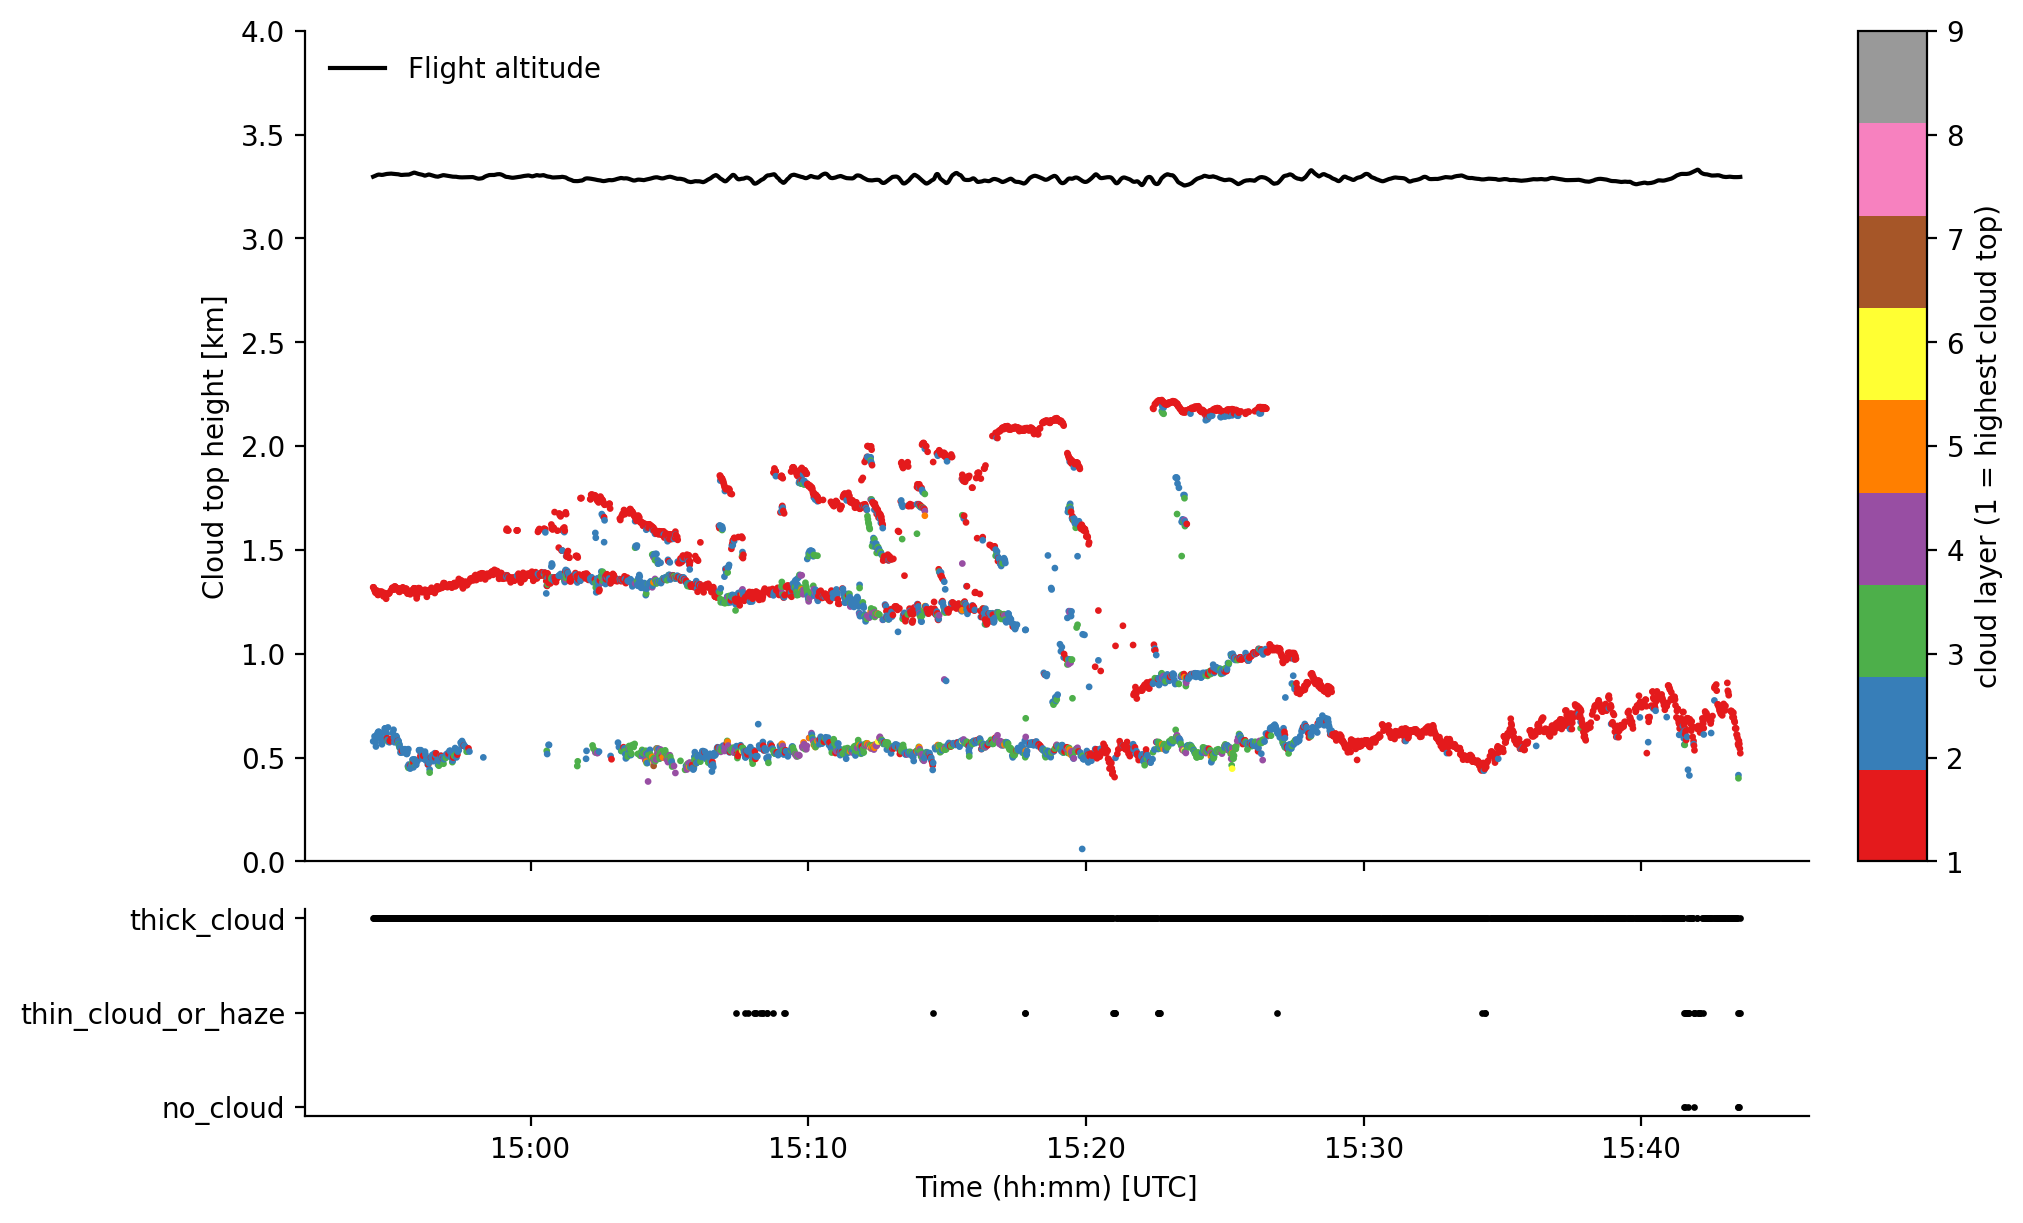

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw=dict(height_ratios=[1, 0.25]))

# 1st: plot flight altitude and cloud top height with seperate colors for each layer
ax1.plot(ds_cloud_top_height_sel.time, ds_cloud_top_height_sel.alt*1e-3, color='k', label='Flight altitude')

stack = ds_cloud_top_height_sel.cloud_top_height.stack({'tl': ['time', 'cloud_layer']})
im = ax1.scatter(x=stack.time, y=stack*1e-3, c=stack.cloud_layer, s=2, vmin=1, vmax=9, cmap='Set1')
fig.colorbar(im, ax=ax1, label='cloud layer (1 = highest cloud top)')
ax1.set_ylim(0, 4)
ax1.set_ylabel('Cloud top height [km]')

ax1.legend(frameon=False, loc='upper left')

# 3rd: plot cloud mask in lower part of the figure
ax2.scatter(ds_cloud_top_height_sel.time, ds_cloud_top_height_sel.cloud_mask, s=2, color='k')
ax2.set_yticks([int(x) for x in ds_cloud_top_height_sel.cloud_mask.attrs['flag_masks'].split(', ')])
ax2.set_yticklabels([x for x in ds_cloud_top_height_sel.cloud_mask.attrs['flag_meanings'].split(' ')])
ax2.set_xlabel('Time (hh:mm) [UTC]')

ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.show()